In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# 【問題1】不純度を求める関数
ノード の ジニ不純度 を計算する関数を作成してください。ノード $t$ に対するジニ不純度 $I(t)$ は以下の数式で求まります。クラスが混じり合っているほどジニ不純度は高くなります。<br>

$I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2}$

$t$ : ノードのインデックス<br>
$i$ : クラスのインデックス<br>
$K$ : クラスの数<br>
$C_i$ : i番目のクラス<br>
$P(C_i|t)$ :　t番目のノードにおける$C_i$の割合<br>
$N_{t,i}$ : t番目のノードのi番目のクラスに属するサンプル数<br>
$N_{t,all}$ : t番目のノードのサンプルの総数<br>

まずは簡単な例を作り、手計算と関数の結果を比較してください。<br>

《例》<br>
クラス1:サンプル数15, クラス2:サンプル数15 → ジニ不純度0.500<br>
クラス1:サンプル数15, クラス2:サンプル数15, クラス3:サンプル数15 → ジニ不純度0.667<br>
クラス1:サンプル数18, クラス2:サンプル数12 → ジニ不純度0.480<br>
クラス1:サンプル数30, クラス2:サンプル数0 → ジニ不純度0.000<br>

In [2]:
def gini_impurity(y):
    K_value, K_counts = np.unique(y, return_counts=True) #K_value　＝　各クラスの値、K_counts　＝　各クラスの個数
    
    gini = 1 - sum((K_counts / len(y))**2)

    return gini

### 手計算

In [3]:
1- (15/30)**2 * 2

0.5

In [4]:
1- (15/45)**2 * 3

0.6666666666666667

In [5]:
1- ((18/30)**2 + (12/30)**2)

0.48

In [6]:
1- ((30/30)**2 + (0/30)**2)

0.0

### 関数

In [7]:
y1 = np.hstack([np.array([1]*15), np.array([2]*15)])
y2 = np.hstack([np.array([1]*15), np.array([2]*15), np.array([3]*15)])
y3 = np.hstack([np.array([1]*18), np.array([2]*12)])
y4 = np.hstack([np.array([1]*30), np.array([2]*0)])
print(gini_impurity(y1))
print(gini_impurity(y2))
print(gini_impurity(y3))
print(gini_impurity(y4))

0.5
0.6666666666666667
0.48
0.0


### 手計算と関数の結果が同じになることを確認。

# 【問題2】情報利得を求める関数
次に、ノード間の 情報利得 を計算する関数を作成してください。問題1で作成したジニ不純度 $I(t)$ を計算する関数を呼び出して使います。情報利得$IG$は以下の数式で求まります。うまく分けられている時ほど情報利得は大きくなります。<br>
ここで分岐は2つのみであるため、分岐先を「左側のノード・右側のノード」と呼びます。<br>

$IG(p) = I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right)$

$p$ : 親ノードを示すインデックス<br>
$left$ : 左側のノードを示すインデックス<br>
$right$ : 右側のノードを示すインデックス<br>

まずは簡単な例を作り、手計算と関数の結果を比較してください。<br>

《例》<br>
左ノードクラス1:サンプル数10, 左ノードクラス2:サンプル数30, 右ノードクラス1:サンプル数20, 右ノードクラス2:サンプル数5 → 情報利得0.143

In [8]:
def information_gain(y, y_left, y_right):
    
    gini_p = gini_impurity(y)
    gini_left = gini_impurity(y_left)
    gini_right = gini_impurity(y_right)

    info_gain = gini_p - (len(y_left) / len(y) * gini_left ) - (len(y_right) / len(y) * gini_right)

    return info_gain

### 手計算

In [9]:
p = 1- ((30/65)**2 + (35/65)**2)
left = 1- ((10/40)**2 + (30/40)**2)
right = 1- ((20/25)**2 + (5/25)**2)
info_gain = p - (40/65 * left) - (25/65 * right)
info_gain

0.14319526627218937

### 関数

In [10]:
y = np.hstack([np.array([1]*30), np.array([2]*35)])
y_left = np.hstack([np.array([1]*10), np.array([2]*30)])
y_right = np.hstack([np.array([1]*20), np.array([2]*5)])
information_gain(y, y_left, y_right)

0.14319526627218937

### 手計算と関数の結果が同じになることを確認。

# 【問題3】学習
空間の分割を行い、決定木のグラフを生成するコードを作成してください。今は深さ1の決定木なので、分割を1回だけ行います。ここでグラフを生成するとは、1回の分割の際の条件としてどの特徴量がいくつ以上の時とするかを求めるということです。<br>

訓練データに対して全ての組み合わせの分割を行い、その中でノード間の情報利得が最大となる分割をそのノードの分割基準として記録します。<br>

クラスが混ざらない不純度が0のノード、または指定された深さのノードが 葉ノード となります。葉ノードにはクラスを記録しておき、これを推定時に分類するクラスとします。クラスが混ざらない場合はそのままのクラスを記録し、混ざっている場合は多数決により決めます。<br>

《組み合わせの取り方》<br>
全ての組み合わせの取り方は、最も単純には各特徴量の値自体をしきい値にして分割を行う方法があります。片側の端は今回のスクラッチはこの方法で行なってください。<br>

他には中間の値をしきい値にする方法もあり、scikit-learnではこの方法が用いられています。<br>

《補足》<br>
問題2の情報利得を計算する関数はこの問題3で利用する上では、親ノードの不純度 $I(p)$ は固定されるため、左右のノードの不純度の合計を計算するだけでも同じ結果が得られることになります。しかし、ここでは親ノードを考慮した情報利得を計算する実装を行なってください。

### ScratchDecesionTreeClassifierDepth1クラスのlearning_function関数とfit関数に回答を記載。

# 【問題4】推定
推定する仕組みを実装してください。ScratchDecesionTreeClassifierDepth1クラスの雛形に含まれるpredictメソッドに書き加えてください。<br>
入力されたデータの値を学習した条件で判定していき、どの葉ノードに到達するかを見ます。葉ノードにはクラスが記録されているので、これが推定値となります。

In [11]:
class ScratchDecesionTreeClassifierDepth1():
    """
    深さ1の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        
    #学習用の関数　　　【問題3】学習
    def learning_function(self, X, y, i, j):
        True_index = np.where(X[:, j] <= X[i, j]) #Trueのインデックスを抽出
        gini_True = self.gini_impurity(y[True_index]) #Trueのジニ不純度を算出
        False_index = np.where(X[:, j] > X[i, j]) #Falseのインデックスを抽出 
        gini_False = self.gini_impurity(y[False_index]) #Falseのジニ不純度を算出
        info_gain = information_gain(y, y[True_index], y[False_index])#情報利得を算出
        
        return True_index, gini_True, False_index, gini_False, info_gain
    
    #【問題3】学習
    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """   
        #特徴量の各要素の値を閾値としてデータを分割し、インデックス・列・情報利得をリストに格納
        info_array = ([])
        for j in range(X.shape[1]):
            for i in range(X.shape[0]):
                True_index, gini_True, False_index, gini_False, info_gain = self.learning_function(X, y, i, j)
                info_array = np.append(info_array, np.array([i, j, info_gain]))

        info_array = info_array.reshape(-1, 3)
        gain_max_index = np.min(np.argmax(info_array[:, -1])) #info_arrayより情報利得最大時のインデックスを抽出
        elements_row = int(info_array[gain_max_index][0]) #情報利得最大時の要素のインデックスを抽出
        elements_column = int(info_array[gain_max_index][1]) #情報利得最大時の要素の列を抽出
        
        #情報利得最大時の学習結果
        True_index, gini_True, False_index, gini_False, info_gain = self.learning_function(X, y, elements_row, elements_column)
        
        self.gini_root = self. gini_impurity(y) #root nodeのジニ不純度
        self.gini_True = gini_True #情報利得最大時のTrue(left)のジニ不純度
        self.gini_False = gini_False #情報利得最大時のFalse(right)のジニ不純度
        self.info_gain = info_gain #最大情報利得
        self.True_samples = len(y[True_index]) #情報利得最大時のTrue(left)のサンプル数
        self.False_samples = len(y[False_index]) #情報利得最大時のFalse(right)のサンプル数
        self.threshold = X[elements_row, elements_column] #情報利得最大時の閾値（要素）
        self.threshold_column = elements_column #情報利得最大時の閾値の特徴量
        
        #Trueのクラスを決定
        True_value, True_counts = np.unique(y[True_index], return_counts=True)
        if len(True_value) == 1:
            True_class = True_value[0]
        else:
            True_class = True_value[np.argmax(True_counts)]
        
        self.True_class = True_class
            
        #Falseのクラスを決定
        False_value, False_counts = np.unique(y[False_index], return_counts=True)
        if len(False_value) == 1:
            False_class = False_value[0]
        else:
            False_class = False_value[np.argmax(False_counts)]
        
        self.False_class = False_class
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print("情報利得：", info_array[:, -1])
            print("情報利得の最大値は{:.3f}です。".format(np.max(info_array[:, -1])))
        
    
    #【問題4】推定
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        True_index = np.where(X[:, self.threshold_column] <= self.threshold) #Trueのインデックスを抽出
        False_index = np.where(X[:, self.threshold_column] > self.threshold) #Falseのインデックスを抽出
        
        True_class = np.vstack([True_index[0], [self.True_class] * len(True_index[0])]) #Trueのインデックスにクラスをマージ
        False_class = np.vstack([False_index[0], [self.False_class] * len(False_index[0])]) #Falseのインデックスにクラスをマージ
        pred_class = np.hstack([True_class, False_class]) #TrueとFalseのクラスをマージ
        
        pred = pred_class[:, np.argsort(pred_class[0, :])][1] #インデックスでソートし、クラスの行を抽出
        
        pass
        return pred
    
    #【問題1】不純度を求める関数
    def gini_impurity(self, y):
        K_value, K_counts = np.unique(y, return_counts=True) #K_value　＝　各クラスの値、K_counts　＝　各クラスの個数

        gini = 1 - sum((K_counts / len(y))**2)

        return gini
    
    #【問題2】情報利得を求める関数
    def information_gain(self, y, y_left, y_right):
        gini_p = self.gini_impurity(y) #親のジニ不純度
        gini_left = self.gini_impurity(y_left) #leftのジニ不純度
        gini_right = self.gini_impurity(y_right) #rightのジニ不純度

        info_gain = gini_p - (len(y_left) / len(y) * gini_left ) - (len(y_right) / len(y) * gini_right)

        return info_gain

# 【問題5】学習と推定
機械学習スクラッチ入門のSprintで用意したシンプルデータセット2の2値分類に対してスクラッチ実装の学習と推定を行なってください。<br>
scikit-learnによる実装と比べ、正しく動いているかを確認してください。<br>
AccuracyやPrecision、Recallなどの指標値はscikit-learnを使用してください。<br>

### シンプルデータセット2作成コード

In [12]:
X_sim2 = np.array([[-0.44699 , -2.8073  ],[-1.4621  , -2.4586  ],
       [ 0.10645 ,  1.9242  ],[-3.5944  , -4.0112  ],
       [-0.9888  ,  4.5718  ],[-3.1625  , -3.9606  ],
       [ 0.56421 ,  0.72888 ],[-0.60216 ,  8.4636  ],
       [-0.61251 , -0.75345 ],[-0.73535 , -2.2718  ],
       [-0.80647 , -2.2135  ],[ 0.86291 ,  2.3946  ],
       [-3.1108  ,  0.15394 ],[-2.9362  ,  2.5462  ],
       [-0.57242 , -2.9915  ],[ 1.4771  ,  3.4896  ],
       [ 0.58619 ,  0.37158 ],[ 0.6017  ,  4.3439  ],
       [-2.1086  ,  8.3428  ],[-4.1013  , -4.353   ],
       [-1.9948  , -1.3927  ],[ 0.35084 , -0.031994],
       [ 0.96765 ,  7.8929  ],[-1.281   , 15.6824  ],
       [ 0.96765 , 10.083   ],[ 1.3763  ,  1.3347  ],
       [-2.234   , -2.5323  ],[-2.9452  , -1.8219  ],
       [ 0.14654 , -0.28733 ],[ 0.5461  ,  5.8245  ],
       [-0.65259 ,  9.3444  ],[ 0.59912 ,  5.3524  ],
       [ 0.50214 , -0.31818 ],[-3.0603  , -3.6461  ],
       [-6.6797  ,  0.67661 ],[-2.353   , -0.72261 ],
       [ 1.1319  ,  2.4023  ],[-0.12243 ,  9.0162  ],
       [-2.5677  , 13.1779  ],[ 0.057313,  5.4681  ]])
y_sim2 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
#シンプルデータセット2
X_data = X_sim2
y_data = y_sim2

# 訓練データと検証データの分割。訓練データ75%、検証データ25%として分割する。
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.75, random_state=123)
    
# #標準化
# scaler = StandardScaler()
# scaler.fit(X_train) #訓練用のデータでfit
# X_train_std = scaler.transform(X_train) #訓練用データをtransform
# X_test_std = scaler.transform(X_test) #検証用データをtransform

In [14]:
#今回スクラッチしたモデル
sdtc = ScratchDecesionTreeClassifierDepth1(verbose=True)
sdtc.fit(X_train, y_train) #学習
y_pred = sdtc.predict(X_test)#推定（クラス）
print(y_pred)
print("正解率：{:.2f}".format(accuracy_score(y_test, y_pred)))
print("適合率：{:.2f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("再現率：{:.2f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("F値：{:.2f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("混同行列：")
print(confusion_matrix(y_test, y_pred))
print("classification_report：") #評価をまとめて出力するやつ
print(classification_report(y_test, y_pred))

情報利得： [5.92592593e-03 3.81349206e-02 2.22222222e-03 1.69029663e-02
 2.47474747e-03 2.41427853e-02 1.20987654e-02 5.00000000e-03
 1.77777778e-02 1.32643202e-02 2.21455939e-02 1.05820106e-04
 1.32643202e-02 5.00000000e-03 2.47474747e-03 4.44444444e-04
 3.33730159e-02 5.55555556e-02 4.44444444e-03 0.00000000e+00
 5.20999468e-04 6.34920635e-04 8.57142857e-03 1.36752137e-03
 2.22222222e-03 6.34920635e-04 2.17777778e-02 1.29501916e-02
 2.98670920e-02 4.48148148e-02 4.66666667e-02 2.68253968e-02
 0.00000000e+00 4.17283951e-02 1.03418803e-02 1.32643202e-02
 4.58730159e-02 2.44444444e-02 1.21669180e-03 7.77777778e-03
 3.96825397e-05 3.82010582e-02 2.72222222e-02 2.77777778e-02
 5.00000000e-03 2.67171717e-02 3.08547009e-02 5.37777778e-02
 4.80469289e-02 5.62466773e-03 1.29501916e-02 3.70370370e-04
 1.45560872e-02 1.20987654e-02 4.44444444e-04 2.21455939e-02
 1.77777778e-02 2.22222222e-03 5.92592593e-03 3.62996481e-03]
情報利得の最大値は0.056です。
[1 0 0 0 0 1 0 0 0 0]
正解率：0.50
適合率：0.62
再現率：0.71
F値：0.67
混同行

In [15]:
#DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=1)
dtc.fit(X_train, y_train) #学習
y_pred = dtc.predict(X_test)#推定（クラス）
print(y_pred)
print("正解率：{:.2f}".format(accuracy_score(y_test, y_pred)))
print("適合率：{:.2f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("再現率：{:.2f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("F値：{:.2f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("混同行列：")
print(confusion_matrix(y_test, y_pred))
print("classification_report：") #評価をまとめて出力するやつ
print(classification_report(y_test, y_pred))

[1 0 0 0 0 1 0 0 0 0]
正解率：0.50
適合率：0.62
再現率：0.71
F値：0.67
混同行列：
[[5 2]
 [3 0]]
classification_report：
              precision    recall  f1-score   support

           0       0.62      0.71      0.67         7
           1       0.00      0.00      0.00         3

    accuracy                           0.50        10
   macro avg       0.31      0.36      0.33        10
weighted avg       0.44      0.50      0.47        10



## スクラッチとscikit-learnで同じ結果となった。

# 【問題6】決定領域の可視化
決定領域を可視化してください。

In [16]:
#2値分類用　グラフ化の関数（説明変数２個のみ対応）
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, clf,  target_names, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel'):
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = clf.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

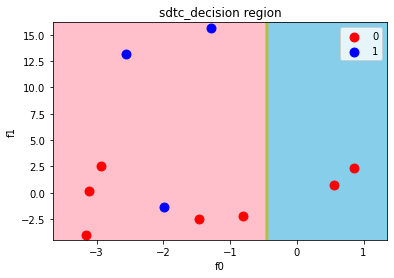

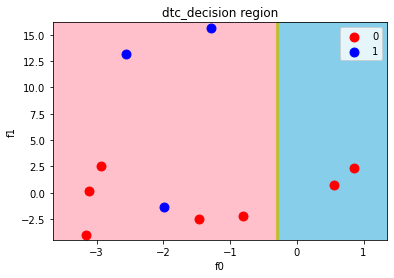

In [17]:
#sdtc : 今回スクラッチしたモデル
decision_region(X_test, y_test, sdtc, step=0.01, title='sdtc_decision region', xlabel='f0', ylabel='f1', target_names=[0, 1])

#dtc : sklearnのモデル
decision_region(X_test, y_test, dtc, step=0.01, title='dtc_decision region', xlabel='f0', ylabel='f1', target_names=[0, 1])

### 閾値の取り方の違いで若干のズレは有るものの、おおよそスクラッチとscikit-learnで同じような位置で決定境界を引くことが出来ている。

# 【問題7】（アドバンス課題）深さ2の決定木分類器クラスの作成
深さが2の決定木分類器のクラスScratchDecesionTreeClassifierDepth2を作成してください。<br>
深さ2とは空間の分割を2回行うことを指します。<br>
《ヒント》<br>
各ノードをインスタンスとして扱うと、任意の深さへの拡張が行いやすくなります。

In [18]:
#深さ１のクラスを深さ２用に小改良
class ScratchDecesionTreeClassifierDepth2_1():
    """
    深さ1の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, verbose=False):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        
    #学習用の関数　　　【問題3】学習
    def learning_function(self, X, y, i, j):
        True_index = np.where(X[:, j] <= X[i, j]) #Trueのインデックスを抽出
        gini_True = self.gini_impurity(y[True_index]) #Trueのジニ不純度を算出
        False_index = np.where(X[:, j] > X[i, j]) #Falseのインデックスを抽出
        gini_False = self.gini_impurity(y[False_index]) #Falseのジニ不純度を算出
        info_gain = information_gain(y, y[True_index], y[False_index])#情報利得を算出
        
        return True_index, gini_True, False_index, gini_False, info_gain
    
    #【問題3】学習
    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """   
        #特徴量の各要素の値を閾値としてデータを分割し、インデックス・列・情報利得をリストに格納
        info_array = ([])
        for j in range(X.shape[1]):
            for i in range(X.shape[0]):
                True_index, gini_True, False_index, gini_False, info_gain = self.learning_function(X, y, i, j)
                info_array = np.append(info_array, np.array([i, j, info_gain]))

        info_array = info_array.reshape(-1, 3)
        gain_max_index = np.min(np.argmax(info_array[:, -1])) #info_arrayより情報利得最大時のインデックスを抽出
        elements_row = int(info_array[gain_max_index][0]) #情報利得最大時の要素のインデックスを抽出
        elements_column = int(info_array[gain_max_index][1]) #情報利得最大時の要素の列を抽出
        
        #情報利得最大時の学習結果
        True_index, gini_True, False_index, gini_False, info_gain = self.learning_function(X, y, elements_row, elements_column)
        
        self.gini_root = self. gini_impurity(y) #root nodeのジニ不純度
        self.gini_True = gini_True #情報利得最大時のTrue(left)のジニ不純度
        self.gini_False = gini_False #情報利得最大時のFalse(right)のジニ不純度
        self.info_gain = info_gain #最大情報利得
        self.True_samples = len(y[True_index]) #情報利得最大時のTrue(left)のサンプル数
        self.False_samples = len(y[False_index]) #情報利得最大時のFalse(right)のサンプル数
        self.threshold = X[elements_row, elements_column] #情報利得最大時の閾値（要素）
        self.threshold_column = elements_column #情報利得最大時の閾値の特徴量
        
        #Trueのクラスを決定
        True_value, True_counts = np.unique(y[True_index], return_counts=True)
        if len(True_value) == 1:
            True_class = True_value[0]
        else:
            True_class = True_value[np.argmax(True_counts)]
        
        self.True_class = True_class
            
        #Falseのクラスを決定
        False_value, False_counts = np.unique(y[False_index], return_counts=True)
        if len(False_value) == 1:
            False_class = False_value[0]
        else:
            False_class = False_value[np.argmax(False_counts)]
        
        self.False_class = False_class
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print("情報利得：", info_array[:, -1])
            print("情報利得の最大値は{:.3f}です。".format(np.max(info_array[:, -1])))
        pass
        
        return True_index, gini_True, False_index, gini_False, info_gain
        
    #【問題4】推定
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """
        True_index = np.where(X[:, self.threshold_column] <= self.threshold) #Trueのインデックスを抽出
        False_index = np.where(X[:, self.threshold_column] > self.threshold) #Falseのインデックスを抽出
        
        True_class = np.vstack([True_index[0], [self.True_class] * len(True_index[0])]) #Trueのインデックスにクラスをマージ
        False_class = np.vstack([False_index[0], [self.False_class] * len(False_index[0])]) #Falseのインデックスにクラスをマージ
        pred_class = np.hstack([True_class, False_class]) #TrueとFalseのクラスをマージ
        
        pred = pred_class[:, np.argsort(pred_class[0, :])][1] #インデックスでソートし、クラスの行を抽出
        
        return True_index, False_index, self.True_class, self.False_class
    
    #【問題1】不純度を求める関数
    def gini_impurity(self, y):
        K_value, K_counts = np.unique(y, return_counts=True) #K_value　＝　各クラスの値、K_counts　＝　各クラスの個数

        gini = 1 - sum((K_counts / len(y))**2)

        return gini
    
    #【問題2】情報利得を求める関数
    def information_gain(self, y, y_left, y_right):
        gini_p = self.gini_impurity(y) #親のジニ不純度
        gini_left = self.gini_impurity(y_left) #leftのジニ不純度
        gini_right = self.gini_impurity(y_right) #rightのジニ不純度

        info_gain = gini_p - (len(y_left) / len(y) * gini_left ) - (len(y_right) / len(y) * gini_right)

        return info_gain

In [19]:
class ScratchDecesionTreeClassifierDepth2():
    """
    深さ2の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, verbose=False, max_depth=None):
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        self.max_depth = max_depth
        
    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """   
        self.sdtc1 = ScratchDecesionTreeClassifierDepth2_1()
        self.sdtc2T = ScratchDecesionTreeClassifierDepth2_1()
        self.sdtc2F = ScratchDecesionTreeClassifierDepth2_1()
        
        True_index, gini_True, False_index, gini_False, info_gain = self.sdtc1.fit(X, y)
        TT_index, gini_TT, TF_index, gini_TF, T_info_gain = self.sdtc2T.fit(X[True_index], y[True_index])
        FT_index, gini_FT, FF_index, gini_FF, F_info_gain = self.sdtc2F.fit(X[False_index], y[False_index])


    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """   
        T_index, F_index, T_class, F_class = self.sdtc1.predict(X)
        TT_index, TF_index, TT_class, TF_class = self.sdtc2T.predict(X)
        FT_index, FF_index, FT_class, FF_class = self.sdtc2F.predict(X)
        
        True_index = np.array(list(set(T_index[0]) & set(TT_index[0]) | set(FF_index[0]))) #Trueのインデックスを抽出
        False_index = np.array(list(set(F_index[0]) & set(FT_index[0]) | set(TF_index[0]))) #Falseのインデックスを抽出
        
        True_class = np.vstack([True_index, [TT_class] * len(True_index)]) #Trueのインデックスにクラスをマージ
        False_class = np.vstack([False_index, [TF_class] * len(False_index)]) #Falseのインデックスにクラスをマージ
        pred_class = np.hstack([True_class, False_class]) #TrueとFalseのクラスをマージ
        
        pred_sort = pred_class[:, np.argsort(pred_class[0, :])] #インデックスでソート
        pred_unique, indices = np.unique(pred_sort[0], return_index=True) #ユニークを抽出
        pred = pred_sort[:, indices][1]
        
        return pred


In [20]:
#今回スクラッチしたモデル
sdtc2 = ScratchDecesionTreeClassifierDepth2(verbose=True, max_depth=2)
sdtc2.fit(X_train, y_train) #学習
y_pred = sdtc2.predict(X_test)#推定（クラス）
print(y_pred)
print("正解率：{:.2f}".format(accuracy_score(y_test, y_pred)))
print("適合率：{:.2f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("再現率：{:.2f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("F値：{:.2f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("混同行列：")
print(confusion_matrix(y_test, y_pred))
print("classification_report：") #評価をまとめて出力するやつ
print(classification_report(y_test, y_pred))

[0 0 1 1 1 0 1 0 1 0]
正解率：0.60
適合率：0.80
再現率：0.57
F値：0.67
混同行列：
[[4 3]
 [1 2]]
classification_report：
              precision    recall  f1-score   support

           0       0.80      0.57      0.67         7
           1       0.40      0.67      0.50         3

    accuracy                           0.60        10
   macro avg       0.60      0.62      0.58        10
weighted avg       0.68      0.60      0.62        10



In [21]:
#2値分類用　グラフ化の関数（説明変数２個のみ対応）
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
def decision_region(X, y, clf,  target_names, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel'):
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = clf.predict(mesh).reshape(mesh_f0.shape)
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
#     plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()
    plt.show()

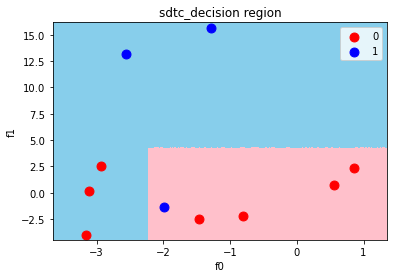

In [22]:
#sdtc2 : 今回スクラッチしたモデル
decision_region(X_test, y_test, sdtc2, step=0.01, title='sdtc_decision region', xlabel='f0', ylabel='f1', target_names=[0, 1])

In [23]:
#DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=2)
dtc.fit(X_train, y_train) #学習
y_pred = dtc.predict(X_test)#推定（クラス）
print(y_pred)
print("正解率：{:.2f}".format(accuracy_score(y_test, y_pred)))
print("適合率：{:.2f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("再現率：{:.2f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("F値：{:.2f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("混同行列：")
print(confusion_matrix(y_test, y_pred))
print("classification_report：") #評価をまとめて出力するやつ
print(classification_report(y_test, y_pred))

[1 0 1 1 1 1 0 0 1 0]
正解率：0.30
適合率：0.50
再現率：0.29
F値：0.36
混同行列：
[[2 5]
 [2 1]]
classification_report：
              precision    recall  f1-score   support

           0       0.50      0.29      0.36         7
           1       0.17      0.33      0.22         3

    accuracy                           0.30        10
   macro avg       0.33      0.31      0.29        10
weighted avg       0.40      0.30      0.32        10



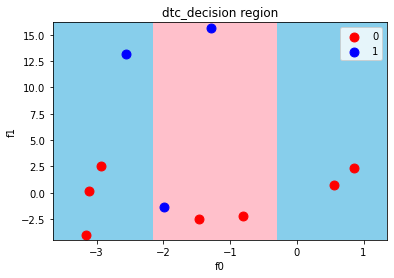

In [24]:
#dtc : sklearnのモデル (max_depth=2)
decision_region(X_test, y_test, dtc, step=0.01, title='dtc_decision region', xlabel='f0', ylabel='f1', target_names=[0, 1])

### sklearnとは結果が異なるが、分類は出来ていると思われる。

# 【問題8】（アドバンス課題）深さに制限のない決定木分類器クラスの作成
深さに制限のない決定木分類器のクラスScratchDecesionTreeClassifierDepthInfを作成してください。


任意の深さを指定できるようにするとともに、指定しない場合は全ての葉ノードがジニ不純度0となるまで続けられるようにもしてください。

In [25]:
#深さ１のクラスを深さ制限無し用に改良
class ScratchDecesionTreeClassifierDepthInf_1():
    """
    深さ1の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, max_depth=None, verbose=False):
        self.max_depth = max_depth
        self.sdtcT = None
        self.sdtcF = None
        self.threshold = None
        self.threshold_column = None
        self._class = None
        self.gini_True = None
        self.gini_False = None
        
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        
    #学習用の関数　　　【問題3】学習
    def learning_function(self, X, y, i, j):
        True_index = np.where(X[:, j] <= X[i, j]) #Trueのインデックスを抽出
        gini_True = self.gini_impurity(y[True_index]) #Trueのジニ不純度を算出
        False_index = np.where(X[:, j] > X[i, j]) #Falseのインデックスを抽出
        gini_False = self.gini_impurity(y[False_index]) #Falseのジニ不純度を算出
        info_gain = information_gain(y, y[True_index], y[False_index])#情報利得を算出
        
        return True_index, gini_True, False_index, gini_False, info_gain
    
    #【問題3】学習
    def fit(self, X, y, depth=1):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """   
        self.depth = depth
        
        #特徴量の各要素の値を閾値としてデータを分割し、インデックス・列・情報利得をリストに格納
        info_array = ([])
        for j in range(X.shape[1]):
            for i in range(X.shape[0]):
                True_index, gini_True, False_index, gini_False, info_gain = self.learning_function(X, y, i, j)
                info_array = np.append(info_array, np.array([i, j, info_gain]))

        info_array = info_array.reshape(-1, 3)
        gain_max_index = np.min(np.argmax(info_array[:, -1])) #info_arrayより情報利得最大時のインデックスを抽出
        elements_row = int(info_array[gain_max_index][0]) #情報利得最大時の要素のインデックスを抽出
        elements_column = int(info_array[gain_max_index][1]) #情報利得最大時の要素の列を抽出
        
        #情報利得最大時の学習結果
        True_index, gini_True, False_index, gini_False, info_gain = self.learning_function(X, y, elements_row, elements_column)
        
        self.threshold = X[elements_row, elements_column] #情報利得最大時の閾値（要素）
        self.threshold_column = elements_column #情報利得最大時の閾値の特徴量
        self.gini_True = gini_True
        self.gini_False = gini_False
        
        #クラスを決定
        value, counts = np.unique(y, return_counts=True)
        if len(value) == 1:
            _class = value[0]
        else:
            _class = value[np.argmax(counts)]
        
        self._class = _class
        
        
        if self.verbose:
            #verboseをTrueにした際は学習過程を出力
            print("情報利得：", info_array[:, -1])
            print("情報利得の最大値は{:.3f}です。".format(np.max(info_array[:, -1])))
        
            
        if self.max_depth == self.depth:
            return       
        
        if self.gini_True == 0:
            pass
        else:
            self.sdtcT = ScratchDecesionTreeClassifierDepthInf_1(self.max_depth)
            self.sdtcT.fit(X[True_index], y[True_index], depth=self.depth+1)
            
        if self.gini_False == 0:
            pass
        else:
            self.sdtcF = ScratchDecesionTreeClassifierDepthInf_1(self.max_depth)
            self.sdtcF.fit(X[False_index], y[False_index], depth=self.depth+1)    

        
    #【問題4】推定
    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """       
        if self.gini_True + self.gini_False == 0 or self.max_depth == self.depth:
            return self._class
        else:
            if X[self.threshold_column] <= self.threshold and self.sdtcT != None:
                return self.sdtcT.predict(X)
            elif X[self.threshold_column] > self.threshold and self.sdtcF != None:
                return self.sdtcF.predict(X)
            else:
                return self._class
    
    #【問題1】不純度を求める関数
    def gini_impurity(self, y):
        K_value, K_counts = np.unique(y, return_counts=True) #K_value　＝　各クラスの値、K_counts　＝　各クラスの個数

        gini = 1 - sum((K_counts / len(y))**2)

        return gini
    
    #【問題2】情報利得を求める関数
    def information_gain(self, y, y_left, y_right):
        gini_p = self.gini_impurity(y) #親のジニ不純度
        gini_left = self.gini_impurity(y_left) #leftのジニ不純度
        gini_right = self.gini_impurity(y_right) #rightのジニ不純度

        info_gain = gini_p - (len(y_left) / len(y) * gini_left ) - (len(y_right) / len(y) * gini_right)

        return info_gain

In [26]:
class ScratchDecesionTreeClassifierDepthInf():
    """
    深さ2の決定木分類器のスクラッチ実装

    Parameters
    ----------
    verbose : bool
      学習過程を出力する場合はTrue
    """
    def __init__(self, max_depth=None, verbose=False):
        self.max_depth = max_depth
        
        # ハイパーパラメータを属性として記録
        self.verbose = verbose
        
        
    def fit(self, X, y):
        """
        決定木分類器を学習する
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        """   
        self.sdtc = ScratchDecesionTreeClassifierDepthInf_1(self.max_depth)
        self.sdtc.fit(X, y)

    def predict(self, X):
        """
        決定木分類器を使いラベルを推定する
        """   
        pred = []
        for s in X:
            pred.append(self.sdtc.predict(s))
            
        return np.array(pred)

In [27]:
#今回スクラッチしたモデル
sdtcInf = ScratchDecesionTreeClassifierDepthInf(max_depth=None, verbose=False)
sdtcInf.fit(X_train, y_train) #学習
y_pred = sdtcInf.predict(X_test)#推定（クラス）
print("正解率：{:.2f}".format(accuracy_score(y_test, y_pred)))
print("適合率：{:.2f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("再現率：{:.2f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("F値：{:.2f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("混同行列：")
print(confusion_matrix(y_test, y_pred))
print("classification_report：") #評価をまとめて出力するやつ
print(classification_report(y_test, y_pred))

正解率：0.40
適合率：0.60
再現率：0.43
F値：0.50
混同行列：
[[3 4]
 [2 1]]
classification_report：
              precision    recall  f1-score   support

           0       0.60      0.43      0.50         7
           1       0.20      0.33      0.25         3

    accuracy                           0.40        10
   macro avg       0.40      0.38      0.38        10
weighted avg       0.48      0.40      0.42        10



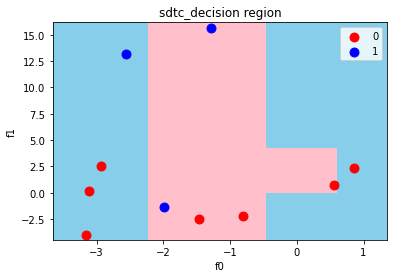

In [28]:
#sdtcInf : 今回スクラッチしたモデル
decision_region(X_test, y_test, sdtcInf, step=0.01, title='sdtc_decision region', xlabel='f0', ylabel='f1', target_names=[0, 1])

In [29]:
#DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=None)
dtc.fit(X_train, y_train) #学習
y_pred = dtc.predict(X_test)#推定（クラス）
print(y_pred)
print("正解率：{:.2f}".format(accuracy_score(y_test, y_pred)))
print("適合率：{:.2f}".format(precision_score(y_test, y_pred, pos_label=0)))
print("再現率：{:.2f}".format(recall_score(y_test, y_pred, pos_label=0)))
print("F値：{:.2f}".format(f1_score(y_test, y_pred, pos_label=0)))
print("混同行列：")
print(confusion_matrix(y_test, y_pred))
print("classification_report：") #評価をまとめて出力するやつ
print(classification_report(y_test, y_pred))

[0 0 1 1 0 0 1 0 1 0]
正解率：0.70
適合率：0.83
再現率：0.71
F値：0.77
混同行列：
[[5 2]
 [1 2]]
classification_report：
              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.50      0.67      0.57         3

    accuracy                           0.70        10
   macro avg       0.67      0.69      0.67        10
weighted avg       0.73      0.70      0.71        10



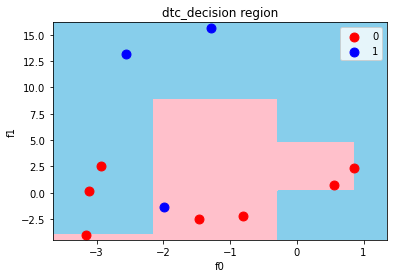

In [30]:
#dtc : sklearnのモデル
decision_region(X_test, y_test, dtc, step=0.01, title='dtc_decision region', xlabel='f0', ylabel='f1', target_names=[0, 1])

### sklearnと比較し、分類が進んでいないように見える。細かい部分が追い切れていない為、今後ブラッシュアップしていく。